<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Your-First-RNN" data-toc-modified-id="Your-First-RNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Your First RNN</a></span><ul class="toc-item"><li><span><a href="#1.-The-data" data-toc-modified-id="1.-The-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. The data</a></span></li></ul></li><li><span><a href="#2.-A-Simple-RNN" data-toc-modified-id="2.-A-Simple-RNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. A Simple RNN</a></span></li><li><span><a href="#Baseline-comparison?" data-toc-modified-id="Baseline-comparison?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline comparison?</a></span></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LSTM</a></span><ul class="toc-item"><li><span><a href="#🏁-Congratulation" data-toc-modified-id="🏁-Congratulation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>🏁 Congratulation</a></span></li></ul></li><li><span><a href="#Utils-(for-reference-only)" data-toc-modified-id="Utils-(for-reference-only)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Utils (for reference only)</a></span></li></ul></div>

# Your First RNN

**Exercise objectives**:

- Better understand temporal data
- Build your first Recurrent Neural Network


<hr>
<hr>

## 1. The data

Let's start with simple sequences of observations:

In [1]:
from tensorflow import keras
import numpy as np

In [2]:
X = np.load('X.npy')
y = np.load('y.npy')

In [3]:
print(X.shape)
print(X[0])

(25000, 10, 3)
[[  0.803     10.728925 102.      ]
 [  0.5       10.728925 102.      ]
 [  0.603     10.728925 102.      ]
 [  0.711     10.728925 130.      ]
 [  0.937     10.728925 130.      ]
 [  1.051     10.728925 130.      ]
 [  1.118     32.       108.      ]
 [  4.87      32.       108.      ]
 [  4.973     33.       108.      ]
 [  5.199     39.       108.      ]]


In [4]:
print(y.shape)
print(y[0])

(25000,)
6.499


☝️ The data describes the evolution of the **employment status of a person, year after year**: each sequence corresponds to 10 consecutive years, where each year describes a job situation, comprising of 3 components
- the salary,
- the number of persons under one's responsability,
- the size of the company. 

So, from this 25000 sequences, each of 10 consecutive observations, the goal is to predict the salary on the 11th year based on the past observations. 

❓ **Question** ❓ Take some sequences and plot the evolution of their salaries, of the persons under their responsibility and of the company sizes. You might see some correlation between the three variables.

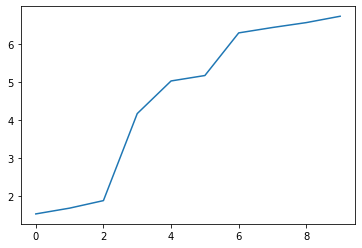

In [26]:
plt.plot(X[1, :, 0])

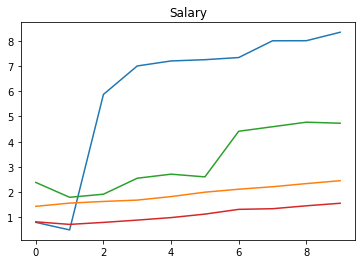

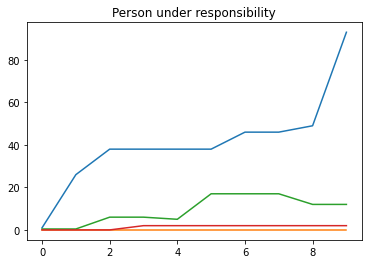

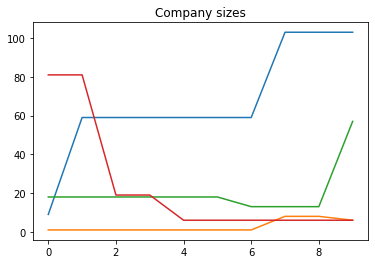

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

random_selection = np.random.randint(0, X.shape[0], 4)

plt.title('Salary')
for r in random_selection:
    plt.plot(X[r, :, 0])
plt.show()

plt.title('Person under responsibility')
for r in random_selection:
    plt.plot(X[r, :, 1])
plt.show()

plt.title('Company sizes')
for r in random_selection:
    plt.plot(X[r, :, 2])
plt.show()

In [6]:
X[1, :, 1].shape

(10,)

❓ **Question** ❓ Plot the distribution of all the salaries, persons under one's responsibility, and company sizes to get a better understanding of the variability of observations

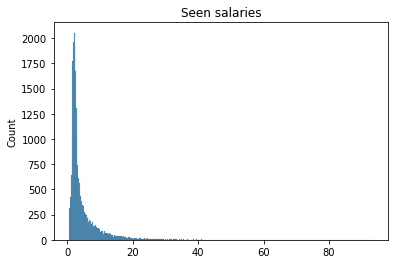

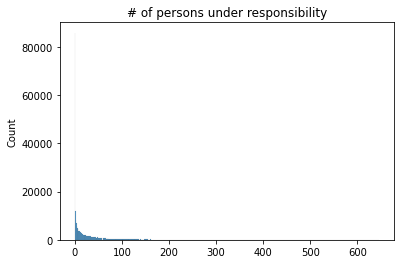

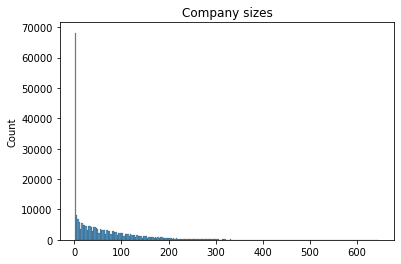

In [7]:
import seaborn as sns
plt.title("Seen salaries")
sns.histplot(X[:, -1, 0].flatten())
plt.show()

plt.title("# of persons under responsibility")
sns.histplot(X[:, :, 1].flatten())
plt.show()

plt.title("Company sizes")
sns.histplot(X[:, :, 2].flatten())
plt.show()

❓ **Question** ❓  Split your dataset between a train and test set (20/80%)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 2. A Simple RNN

Now, you will create your first Recurrent Neural Network. Let's start simple

❓ **Question** ❓ Write a model that has: 
- a `Normalization` layer adapted on the training set
- a `SimpleRNN` layer with 20 `units` - don't forget to choose the `tanh` activation function
- a Dense layer with 10 neurons
- a last Dense layer specific to your task (predict a salary)

Remember, you don't need to specify an `input_shape`: as soon as your normalizer has been adapted to your train set, it has memorized it.

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten

normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X_train)[0]

2022-02-17 09:55:16.283112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 09:55:16.326333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[-0.31476265, -0.5634355 , -0.14394632],
       [-0.2858199 , -0.5634355 , -0.14394632],
       [-0.23872209, -0.54651487, -0.14394632],
       [-0.20478012, -0.54651487, -0.14394632],
       [-0.19136116, -0.5011188 , -0.14394632],
       [-0.13373876, -0.5692129 , -0.8151276 ],
       [-0.25293037, -0.5692129 , -0.8151276 ],
       [-0.2308286 , -0.5692129 , -0.8151276 ],
       [-0.20977934, -0.5692129 , -0.8151276 ],
       [-0.18767755, -0.5692129 , -0.8151276 ]], dtype=float32)>

In [15]:
model = Sequential()
model.add(normalizer)
model.add(SimpleRNN(units=20, activation='tanh'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, None, 3)           7         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                480       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 708
Trainable params: 701
Non-trainable params: 7
_________________________________________________________________


❓ **Question** ❓ Compute the number of trainable parameters of your model using `model.summary`. 

Then, try to recompute them by hand

💡 Hints: 
- Your `normalization` layer has 7 non-trainable params, which comprise of the mean and standard deviation of each 3 features (salary, persons under responsibility, company size) plus one bias set to 0

- If $\color{green}{n_h}$ RNN units are applied in parallel to $\color{red}{n_x}$ features, the layer has $\color{green}{n_h}(\color{green}{n_h} + \color{red}{n_x} + 1)$ parameters to train. Notice how this number is *independent* of the length of each sequences (here 10 days)


In [14]:
7 + \
(20 * 3) + (20**2) + 20 + \
10 * 20 + 10 + \
1 * 10 + 1

708

❓ **Question** ❓ Compile your model. Remember to first use the `rmsprop` optimizer (instead of Adam).

In [16]:
def compile_model(model):
    model.compile(loss='mse',
                  optimizer='rmsprop', 
                  metrics=['mae'])
    return model

model = compile_model(model)

❓ **Question** ❓ Run your model on your data. Use a validation split of 20% and an early stopping criterion (patience=5). Evaluate your performance on the test set

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100, 
          batch_size=32, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 15.6241 - mae: 1.5317 - val_loss: 3.7101 - val_mae: 0.6224
Epoch 2/100
500/500 [==============================] - 1s 3ms/step - loss: 2.4840 - mae: 0.5195 - val_loss: 1.7346 - val_mae: 0.4697
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 1.4442 - mae: 0.4214 - val_loss: 1.3787 - val_mae: 0.5352
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 1.0878 - mae: 0.3797 - val_loss: 1.0492 - val_mae: 0.3476
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 0.9331 - mae: 0.3576 - val_loss: 0.9124 - val_mae: 0.3017
Epoch 6/100
500/500 [==============================] - 1s 3ms/step - loss: 0.8357 - mae: 0.3495 - val_loss: 0.9191 - val_mae: 0.3515
Epoch 7/100
500/500 [==============================] - 1s 3ms/step - loss: 0.7833 - mae: 0.3407 - val_loss: 0.7945 - val_mae: 0.2842
Epoch 8/100
500/500 [==============================] - 1s 2ms/step -

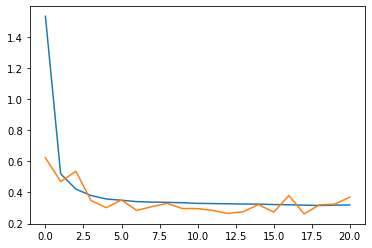

In [19]:
plt.plot(_.history["mae"])
plt.plot(_.history["val_mae"])

In [20]:
model_mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Model Mean Absolute Error {model_mae[1]:.4f}')

Model Mean Absolute Error 0.2840


# Baseline comparison?


In the case of a usual regression model, a baseline prediction for `y_test` could be to predict the average of `y_train`.

With temporal data, it often happens that you try to predict a value that you have already seen in the past: here, the salary. In that case, a baseline model could be to predict for instance that the 11-th salary is equal to the 10-th salary.

❓ **Question** ❓ Compute the Mean Absolute Error of a model that would predict that the salary remains constant between the 10-th and 11-th year and compare it to your RNN.

In [25]:
##############
### Answer ###
##############

def constant_prediction(X, y):
    error = []
    for xx, yy in zip(X, y):
        last_salary = xx[-1][0]
        error.append(yy - last_salary)
        
    print(len(error))
    return error

error = constant_prediction(X, y)

print(f'Constant Mean Absolute Error {np.mean(np.abs(error)):.4f}')

25000
Constant Mean Absolute Error 0.5952


You have probably seen that your prediction is a little bit better than the baseline model

# LSTM

❓ **Question** ❓ Write the exact same model, but with a `LSTM` instead of a `SimpleRNN` and evaluate your performance on the test set

In [23]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

model_LSTM = Sequential()
model_LSTM.add(normalizer)
model_LSTM.add(LSTM(units=20, activation='tanh'))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(1, activation='linear'))

model_LSTM = compile_model(model_LSTM)

es = EarlyStopping(patience=5, restore_best_weights=True)

history_LSTM = model_LSTM.fit(X_train, y_train,
          epochs=100, 
          batch_size=32, 
          validation_split=0.2,
          callbacks=[es], verbose=0)

## 🏁 Congratulation

You now know how to run RNN on sequence data!

Note: The sequences you worked with are totally fake. In case you need to train and reproduce similar data, you can find bellow the functions that have been used to simulate this data.

# Utils (for reference only)

In [0]:
def create_sequences(number):
    X, y = [], []
    
    for i in range(number):
        x_i, y_i = create_individual_sequence(10)
        X.append(x_i)
        y.append(y_i)
        
    return np.array(X), np.array(y)
            
def create_individual_sequence(length):
    company_sizes = []
    nb_persons = []
    salaries = []
    
    
    # Education level
    educ_level = [max(0, int(np.random.normal(10, 2)))]*length
    
    # Company size
    current_size = int(1 + np.random.beta(.4, 4)*500)
    for i in range(length):
        if not np.random.randint(4): # Change 1 out of 3 possibilities 
            current_size = int(max(1, np.random.normal(current_size, 50)))
        company_sizes.append(current_size)
    
    # Number of persons
    nb_iter = np.random.beta(.15, 4)*300
    for i in range(length):
        if not np.random.randint(2): # Change 1 out of 2 possibilities
            R_1 = np.random.beta(0.5, 8)*3
            nb_iter = nb_iter + max(-2, R_1*company_sizes[i] + np.random.randint(-2, 2))
            nb_iter = max(0, nb_iter)
            nb_iter = int(min(company_sizes[i]-1, nb_iter))
        nb_persons.append(nb_iter)
        
    
    # Salary
    salary_iter = max(800, int(np.random.normal(1200, 300)+ 0.05*company_sizes[0] +  np.random.normal(40, 400)))
    salaries.append(salary_iter)
    for i in range(1, length + 1):
        R_1 = np.random.normal(100, 50)
        change_person = nb_persons[i-1] - nb_persons[i-2]
        change_company = max(0, company_sizes[i-1] - company_sizes[i-2])
        salary_iter = salary_iter + 0.05*change_company + change_person*R_1 + np.random.normal(100, 50)
        salary_iter = max(int(salary_iter), 500)
        
        salaries.append(salary_iter)

    y = salaries[-1]/1000
    salaries = [_/1000 for _ in salaries[:-1]]
    
    return np.array([salaries, nb_persons, company_sizes]).T, y

In [0]:
#X, y = create_sequences(25000)

#np.save('X', X.astype(np.float32))
#np.save('y', y)